In [12]:
from setup import *
from utils import *

import cv2

In [14]:
dist_to_origin = 4.0
fov = 100

checker_board = mi.load_dict({
    'type': 'ply',
    'filename': 'test_scenes/meshes/checkerboard.ply',
    'face_normals': True,
    'bsdf': {
        'type': 'diffuse',
        'id': 'gray-bsdf',
        'reflectance': {'type': 'spectrum', 'value': 0.05},
        },
    'to_world': mi.ScalarTransform4f.rotate([0,1,0], 90),
    })

scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'path'},
    'sensor': {
        'type': 'perspective',
        'near_clip': 0.01,
        'far_clip': 1000.0,
        'fov': fov,
        'fov_axis': 'x', # x is the default
        'film': {
            'type': 'hdrfilm',
            'rfilter': { 'type': 'gaussian' },
            'width': 1280,
            'height': 800,
        },
        'sampler': {
            'type': 'independent',
            'sample_count': 128,
        },
        'to_world': mi.ScalarTransform4f.look_at(origin=[dist_to_origin, 0.0, 0.0], target=[0.0, 0.0, 0.0], up=[0.0, 0.0, 1.0])
    },

    'checker_board': checker_board,

    'light': {
        'type': 'constant'
    }
}

scene = mi.load_dict(scene_dict)
render = mi.render(scene)
mi.Bitmap(render)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1280, 800],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 11.7 MiB of image data ]
]

In [3]:
posns = []
num_posns = 11
delta_theta = np.pi/(num_posns+1)
for i in range(1, num_posns+1):
    posns.append([dist_to_origin*np.cos(i*delta_theta-np.pi/2), dist_to_origin*np.sin(i*delta_theta-np.pi/2), 0.0])
for i in range(1, num_posns+1):
    posns.append([dist_to_origin*np.cos(i*delta_theta-np.pi/2), 0.0, dist_to_origin*np.sin(i*delta_theta-np.pi/2)])
total_posns = len(posns)

scene_params = mi.traverse(scene)

renders = []
for i in range(total_posns):
    scene_params['sensor.to_world'] = mi.ScalarTransform4f.look_at(origin=posns[i], target=[0.0, 0.0, 0.0], up=[0.0, 0.0, 1.0])
    scene_params.update()
    renders.append(mi.render(scene))

fig, ax = plt.subplots(1,total_posns)
for i in range(total_posns):
    ax[i].imshow(renders[i]/np.max(renders[i]))
    ax[i].axis('off')

In [8]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,8,0)
objp = np.zeros((9*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:9].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

rets = []
i = 0
for img in renders:
    img = np.array(np.average(img, axis=2)*255, dtype=np.uint8) # convert render to single channel uint8 numpy array

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (9,9), None)

    # If corners are found, add the object points and image points (after doing subpixel refinement)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(img, corners, 
                                    (11,11), # search window
                                    (-1,-1), # zero zone (not used)
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)) # termination criteria
        imgpoints.append(corners2)
        rets.append(i)

    i += 1

# print(objpoints)
# print(imgpoints)

In [9]:
img = np.array(np.average(renders[0], axis=2)*255, dtype=np.uint8) # just to later get the shape...

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)

print(mtx)
print(dist)

[[537.75269239   0.         639.39234351]
 [  0.         537.76390293 399.38918647]
 [  0.           0.           1.        ]]
[[-1.86173194e-02  3.16473120e-01 -8.47504074e-05 -9.08913515e-05
  -2.17663086e+00]]


Translation Vector:
 [[-3.72413039e-03]
 [-3.68926488e-03]
 [ 3.99952848e+00]]

Rotation Vector:
 [[-2.22134824e+00]
 [-1.61306866e-05]
 [ 2.22147342e+00]]

Rotation Matrix:
 [[-5.63489722e-05 -2.33781910e-05 -9.99999998e-01]
 [ 3.79007024e-05 -9.99999999e-01  2.33760554e-05]
 [-9.99999998e-01 -3.78993851e-05  5.63498582e-05]]



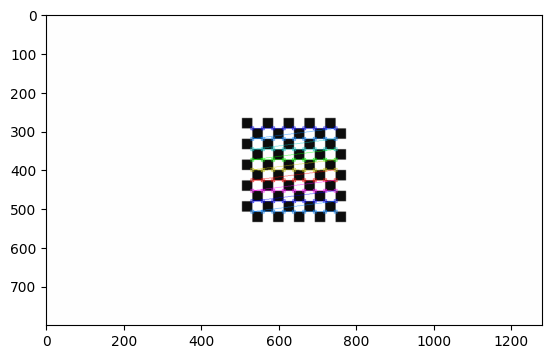

In [10]:
i = 3

objp_t = np.fliplr(np.mgrid[0:9,0:9].T.reshape(-1,2))*-0.2+0.8
objp_t = np.concatenate([np.zeros((9*9,1)), objp_t], axis=1)
# print('World Coordinates of Object Points:\n', objp_t, end='\n\n')
# print('Image Coordinates:\n', imgpoints[i], end='\n\n')

# ret, rvec, tvec = cv2.solvePnP(objp_t, imgpoints[i], mtx, dist)
ret, rvec, tvec = cv2.solvePnP(objp_t, imgpoints[i], get_ideal_camera_matrix(fov, 1280, 800, 'x'), None)
print('Translation Vector:\n', tvec, end='\n\n')
print('Rotation Vector:\n', rvec, end='\n\n')

R, _ = cv2.Rodrigues(rvec)
print('Rotation Matrix:\n', R, end='\n\n')

drawn = np.array(renders[rets[i]]/np.max(renders[rets[i]]))
drawn = cv2.drawChessboardCorners(drawn, (9,9), imgpoints[i], True)
plt.imshow(drawn)

In [11]:
camera_posn = -(R.T)@tvec
print("Camera Position:\n", camera_posn.flatten(), end='\n\n')
print("True Camera Position:\n", posns[rets[i]], end='\n\n')

print("Difference:", camera_posn.flatten() - posns[rets[i]])
print("Difference Magnitude:", np.linalg.norm(camera_posn.flatten() - posns[rets[i]]))

Camera Position:
 [ 3.99952840e+00 -3.53777227e-03 -3.94941700e-03]

True Camera Position:
 [4.0, 0.0, 0.0]

Difference: [-0.0004716  -0.00353777 -0.00394942]
Difference Magnitude: 0.005323169622619549
